# Auto-Encoder Example

Build a 2 layer auto-encoder with Tensorflow v2 to compress images to a lower latent space and then reconstruct them

In [1]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf

In [5]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate: float = 0.01
training_steps: int = 20000
batch_size: int = 256
display_step: int = 1000

# Network Parameters
num_hidden_1: int = 128 # 1st layer num features.
num_hidden_2: int = 64 # 2nd layer num features (the latent dim).

In [6]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [8]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [18]:
# Store layers weights and biases

# A random value generator to initialize weights
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features]))
}

biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features]))
}

In [19]:
# Building the encoder
def encoder(x):
  # Encoder Hidden layer with sigmoid activation
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
  # Encoder Hidden layer with sigmoid activation
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))

  return layer_2

# Build the decoder
def decoder(x):
  # Decoder Hidden layer with sigmoid activation
  layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
  # Decoder Hidden layer with sigmoid actication
  layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))

  return layer_2

In [20]:
# Mean square loss between original images and reconstructed ones
def mean_square(reconstructed, original):
  return tf.reduce_mean(tf.pow(original - reconstructed, 2))

# Adam Optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [28]:
# from tensorflow.python.ops.variables import trainable_variables
# Optimizaton process
def run_optimization(x):
  # Wrap computation inside a GradientTape for automatic differentiation
  with tf.GradientTape() as g:
    reconstructed_image = decoder(encoder(x))
    loss = mean_square(reconstructed_image, x)

    # Variable to update, i.e. trainable variables
    trainable_variables = trainable_variables = list(weights.values()) + list(biases.values())
    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [29]:
# Run training for the given number of steps
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
  # Run the optimization
  loss: float = run_optimization(batch_x)

  if step % display_step == 0:
    print(f"step: {step}, loss: {loss}")

step: 0, loss: 0.23337547481060028
step: 1000, loss: 0.018295511603355408
step: 2000, loss: 0.010463781654834747
step: 3000, loss: 0.008184465579688549
step: 4000, loss: 0.006707032211124897
step: 5000, loss: 0.006626393646001816
step: 6000, loss: 0.005636452231556177
step: 7000, loss: 0.005769019015133381
step: 8000, loss: 0.005234881304204464
step: 9000, loss: 0.0051084537990391254
step: 10000, loss: 0.004619719926267862
step: 11000, loss: 0.004286916460841894
step: 12000, loss: 0.00434762192890048
step: 13000, loss: 0.004349449649453163
step: 14000, loss: 0.004264104645699263
step: 15000, loss: 0.004115995019674301
step: 16000, loss: 0.003943758551031351
step: 17000, loss: 0.003924428950995207
step: 18000, loss: 0.004081491380929947
step: 19000, loss: 0.0036877247039228678
step: 20000, loss: 0.003455507569015026


In [30]:
# Testing and Visualization.
import matplotlib.pyplot as plt

Original Images


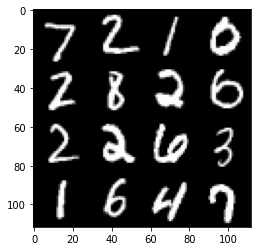

Reconstructed Images


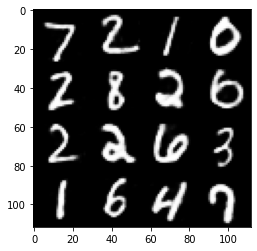

In [31]:
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()